In [18]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data

In [19]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
# !ls /home/aistudio/work

In [20]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/69/bf/f0f194d3379d3f3347478bd267f754fc68c11cbf2fe302a6ab69447b1417/beautifulsoup4-4.10.0-py3-none-any.whl
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/72/a6/fd01694427f1c3fcadfdc5f1de901b813b9ac756f0806ef470cfed1de281/soupsieve-2.3.1-py3-none-any.whl


In [21]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [22]:
import pandas as pd
import os
import pdb
from multiprocessing import cpu_count
import numpy as np
import shutil
import paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import jieba

In [23]:
all_train_list = []
all_test_list = []
train_frame = pd.read_csv('train.csv') 
test_frame = pd.read_csv('test.csv') 
train_frame['Report Content'] = train_frame['Report Content'].apply(lambda x: x.split('##'))
test_frame['Report Content'] = test_frame['Report Content'].apply(lambda x: x.split('##'))
all_test_num=test_frame.shape[0]
all_num=train_frame.shape[0]
for num in range(all_num): 
    all_train_list.append(str(train_frame["label"][num])+"\t"+train_frame["Title"][num]+"\n")
for num in range(all_test_num): 
    all_test_list.append(str(test_frame["label"][num])+"\t"+test_frame["Title"][num]+"\n")

In [24]:
#全部训练集数据进行乱序后写入all_train_data.txt
data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_train_data.txt"

#在生成all_train_data.txt之前，首先将其清空
#写入的字符串包含换行符，可以达到写入多行的效果
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate()  
with open(all_data_path, 'a') as f:
    for data in all_train_list:
        f.write(data) 

In [25]:
#全部测试集数据进行乱序后写入all_test_data.txt
data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_test_data.txt"

#在生成all_test_data.txt之前，首先将其清空
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate()  
with open(all_data_path, 'a') as f:
    for data in all_test_list:
        f.write(data) 

In [26]:
#全部数据进行乱序后写入all_data.txt
data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_data.txt"
all_data_list = all_train_list + all_test_list


#在生成all_data.txt之前，首先将其清空
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(all_data_path, 'a') as f:
    for data in all_data_list:
        f.write(data) 

In [27]:
# 数据处理
x_train=[]
x_test=[]
y_train=[]
y_test=[]
# readlines读入所有数据，如果文件（待读入）的数据过大则不适宜
with open(os.path.join(data_list_path, 'all_train_data.txt'), 'r', encoding='utf-8') as f_train_data:
    train_lines = f_train_data.readlines()
with open(os.path.join(data_list_path, 'all_test_data.txt'), 'r', encoding='utf-8') as f_test_data:
    test_lines = f_test_data.readlines()
for line in train_lines:
    words = line.split('\t')[-1].replace('\n', '')
    label = line.split('\t')[0]
    x_train.append(words)
    y_train.append(label)
for line in test_lines:
    words = line.split('\t')[-1].replace('\n', '')
    label = line.split('\t')[0]
    x_test.append(words)
    y_test.append(label)
print("x_train,x_test,y_train,y_test生成完成！")

x_train,x_test,y_train,y_test生成完成！


In [28]:
# 特征工程：文本特征抽取-tfid
transfer = TfidfVectorizer()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)

In [29]:
# 方法一：朴素贝叶斯算法
 # 1.朴素贝叶斯算法预估器
estimator = MultinomialNB()
estimator.fit(x_train, y_train)

# 2.模型评估（计算准确率）
score = estimator.score(x_test, y_test)
y_predict = estimator.predict(x_test)
report = classification_report(y_test, y_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
print(report)

准确率为:0.900700 
 AUC为:0.684585 

              precision    recall  f1-score   support

         非谣言       0.90      0.99      0.94      8659
          谣言       0.87      0.38      0.53      1482

   micro avg       0.90      0.90      0.90     10141
   macro avg       0.88      0.68      0.74     10141
weighted avg       0.90      0.90      0.88     10141



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [30]:
# 方法二：决策树算法
# 1.决策树预估器
estimator = DecisionTreeClassifier(criterion="entropy")
estimator.fit(x_train, y_train)
# 2.模型评估（计算准确率）
score = estimator.score(x_test, y_test)
y_predict = estimator.predict(x_test)
report = classification_report(y_test, y_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
print(report)

准确率为:0.899615 
 AUC为:0.679476 

              precision    recall  f1-score   support

         非谣言       0.90      0.99      0.94      8659
          谣言       0.87      0.37      0.52      1482

   micro avg       0.90      0.90      0.90     10141
   macro avg       0.89      0.68      0.73     10141
weighted avg       0.90      0.90      0.88     10141



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [31]:
# 方法三 ：随机森林算法
# 1.随即森林预估器
estimator =RandomForestClassifier()

# 2.参数准备
param_dict = {"n_estimators": [90,100,110], "max_depth":[500,750,1000]}
estimator = GridSearchCV(estimator, param_dict, cv=3)
estimator.fit(x_train, y_train)

# 3.模型评估(计算准确率)
score = estimator.score(x_test, y_test)
y_predict = estimator.predict(x_test)
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
# best_params_:最佳参数
print("最佳参数: \n", estimator.best_params_)
# best_score: 在交叉验证中验证的最好结果_
print("最佳结果：\n", estimator.best_score_)
# best_estimator：最佳估计器
print("最佳估计器：\n", estimator.best_estimator_)
# cv_results_: 每次交叉验证后的验证集准确率结果和训练集准确率结果
print("交叉验证器: \n", estimator.cv_results_)

准确率为:0.903856 
 AUC为:0.689509 

最佳参数: 
 {'max_depth': 1000, 'n_estimators': 100}
最佳结果：
 0.9676962312269765
最佳估计器：
 RandomForestClassifier(max_depth=1000)
交叉验证器: 
 {'mean_fit_time': array([14.85936085, 16.53700233, 18.16530013, 16.04057185, 17.87336604,
       19.62751389, 16.49975268, 18.39632424, 20.20410784]), 'std_fit_time': array([1.23214487, 1.29136437, 1.45330659, 1.51399555, 1.68998751,
       1.84341831, 1.58377373, 1.75640723, 1.95435695]), 'mean_score_time': array([0.44730369, 0.49632295, 0.54543646, 0.61377343, 0.6811084 ,
       0.74978765, 0.76190344, 0.8481582 , 0.93057521]), 'std_score_time': array([0.00954613, 0.01083484, 0.011835  , 0.00861932, 0.0103134 ,
       0.01287569, 0.00851975, 0.01204048, 0.01028258]), 'param_max_depth': masked_array(data=[500, 500, 500, 750, 750, 750, 1000, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': 

In [32]:
# 方法四：KNN算法（添加网格搜索和交叉验证）
# 如果一个样本在特征空间中的k个最相似(即特征空间中最邻近（通过欧氏距离计算）)的样本中的大多数属于某一个类别，则该样本也属于这个类别。
# 1.标准化
transfer = StandardScaler(with_mean=False)
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
# 2.KNN算法预估器
estimator = KNeighborsClassifier()

# 3.加入网格算法交叉验证
# 超参数搜索-网格搜索
param_dict = {"n_neighbors": [1, 2, 3, 4, 5]}
estimator = GridSearchCV(estimator, param_dict, cv=10)
estimator.fit(x_train, y_train)

# 4.模型评估(计算准确率)
score = estimator.score(x_test, y_test)
y_predict = estimator.predict(x_test)
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
# best_params_:最佳参数
print("最佳参数: \n", estimator.best_params_)
# best_score: 在交叉验证中验证的最好结果_
print("最佳结果：\n", estimator.best_score_)
# best_estimator：最佳估计器
print("最佳估计器：\n", estimator.best_estimator_)
# cv_results_: 每次交叉验证后的验证集准确率结果和训练集准确率结果
print("交叉验证器: \n", estimator.cv_results_)

准确率为:0.902081 
 AUC为:0.670573 

最佳参数: 
 {'n_neighbors': 1}
最佳结果：
 0.9739360705162877
最佳估计器：
 KNeighborsClassifier(n_neighbors=1)
交叉验证器: 
 {'mean_fit_time': array([0.00488825, 0.00493941, 0.00491607, 0.00491459, 0.00491936]), 'std_fit_time': array([1.97040480e-04, 5.36765107e-05, 3.05628534e-05, 3.22170554e-05,
       3.60038974e-05]), 'mean_score_time': array([0.26046228, 0.27633371, 0.29019973, 0.32899864, 0.32911835]), 'std_score_time': array([0.00111505, 0.00176159, 0.00091182, 0.01869933, 0.01692365]), 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 3}, {'n_neighbors': 4}, {'n_neighbors': 5}], 'split0_test_score': array([0.84419263, 0.79225685, 0.79603399, 0.82719547, 0.81964117]), 'split1_test_score': array([0.93578848, 0.84985836, 0.84891407, 0.89423985, 0.87629839]), 'split2_test_score': array([1.     

In [33]:
# 方法五：支持向量机(1)
# 1.使用高斯核函数配置的支持向量机回归模型
estimator=svm.SVC(kernel='rbf',C=1000)
estimator.fit(x_train,y_train)
# 2.模型评估（计算准确率）
score = estimator.score(x_test,y_test)
y_predict = estimator.predict(x_test)
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
report = classification_report(y_test, y_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print(report)

准确率为:0.902968 
 AUC为:0.683117 

              precision    recall  f1-score   support

         非谣言       0.90      0.99      0.95      8659
          谣言       0.91      0.37      0.53      1482

   micro avg       0.90      0.90      0.90     10141
   macro avg       0.91      0.68      0.74     10141
weighted avg       0.90      0.90      0.88     10141



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [34]:
# 方法五：支持向量机(2)
# 1.使用Sigmoid核函数配置的支持向量机回归模型
estimator=svm.SVC(kernel='sigmoid',C=1000)
estimator.fit(x_train,y_train)
# 2.模型评估（计算准确率）
score = estimator.score(x_test,y_test)
y_predict = estimator.predict(x_test)
report = classification_report(y_test, y_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
print(report)

准确率为:0.901883 
 AUC为:0.695065 

              precision    recall  f1-score   support

         非谣言       0.91      0.99      0.95      8659
          谣言       0.84      0.40      0.55      1482

   micro avg       0.90      0.90      0.90     10141
   macro avg       0.88      0.70      0.75     10141
weighted avg       0.90      0.90      0.89     10141



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [35]:
# 方法五：支持向量机(3)
# 1.使用线性核函数配置的支持向量机回归模型
model=svm.SVC(kernel='linear',C=1000)
model.fit(x_train,y_train)
# 2.模型评估（计算准确率）
score = estimator.score(x_test,y_test)
y_predict = estimator.predict(x_test)
report = classification_report(y_test, y_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print("准确率为:%f \n AUC为:%f \n" %(score,roc_auc_score(list(map(int, y_test)), list(map(int, y_predict)))))
print(report)

准确率为:0.901883 
 AUC为:0.695065 

              precision    recall  f1-score   support

         非谣言       0.91      0.99      0.95      8659
          谣言       0.84      0.40      0.55      1482

   micro avg       0.90      0.90      0.90     10141
   macro avg       0.88      0.70      0.75     10141
weighted avg       0.90      0.90      0.89     10141



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [36]:
# 分词操作
def cut_word(text):
    text = " ".join(list(jieba.cut(text)))
    return text

In [37]:
model_true=[]
# 生成数据字典
def create_dict(data_path, dict_path):
    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        for s in line.split(" "):
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
    print("数据字典生成完成！")
    
    
# 获取字典的长度
def get_dict_len(dict_path):
    with open(dict_path, 'r', encoding='utf-8') as f:
        line = eval(f.readlines()[0])
    return len(line.keys())

In [38]:
# 创建序列化表示的数据
def create_data_list(data_list_path):
    #在生成数据之前，首先将eval_list.txt和train_list.txt清空

    # 往文件中写入
    # os.path.join()   函数功能：连接两个或更多的路径名组件，如果各组件名首字母不包含’/’，则函数会自动加上，如果最后一个组件为空，则生成的路径以一个’/’分隔符结尾
    with open(os.path.join(data_list_path, 'e_split_list.txt'), 'w', encoding='utf-8') as f_eval:
        f_eval.seek(0)
        f_eval.truncate()
        
    with open(os.path.join(data_list_path, 't_split_list.txt'), 'w', encoding='utf-8') as f_train:
        f_train.seek(0)
        f_train.truncate() 
    
    # 以只读的形式打开文件
    # str.split(str="",num=string.count(str))[n]  str： 表示为分隔符，默认为空格，但是不能为空(’’)。若字符串中没有分隔符，则把整个字符串作为列表的一个元素   
    # num：表示分割次数。如果存在参数num，则仅分隔成 num+1 个子字符串，并且每一个子字符串可以赋给新的变量
    # [n]： 表示选取第n个分片   注意：当使用空格作为分隔符时，对于中间为空的项会自动忽略
    # readlines()   读取整个文件所有行，保存在一个列表(list)变量中，每行作为一个元素
    with open(os.path.join(data_list_path, 'dict_split.txt'), 'r', encoding='utf-8') as f_data: 
        dict_txt = eval(f_data.readlines()[0])

    with open(os.path.join(data_list_path, 'split_train_data.txt'), 'r', encoding='utf-8') as f_train_data:
        train_lines = f_train_data.readlines()

    with open(os.path.join(data_list_path, 'split_test_data.txt'), 'r', encoding='utf-8') as f_test_data:
        test_lines = f_test_data.readlines()

    with open(os.path.join(data_list_path, 'e_split_list.txt'), 'a', encoding='utf-8') as f_eval,open(os.path.join(data_list_path, 't_split_list.txt'), 'a', encoding='utf-8') as f_train:
        for line in train_lines:
            label = line.split('\t')[0]
            labs = ""
            for s in line.split(" ")[1:]:
                lab = str(dict_txt[s])
                labs = labs + lab + ','
            labs = labs[:-1]
            labs = labs + '\t' + label + '\n'
            f_train.write(labs)
        for line in test_lines:
            label = line.split('\t')[0]
            # model_true.append(int(label))
            labs = ""
            for s in line.split(" ")[1:]:
                lab = str(dict_txt[s])
                labs = labs + lab + ','
            labs = labs[:-1]
            labs = labs + '\t' + label + '\n'
            f_eval.write(labs) 
        
    print("数据列表生成完成！")

In [39]:
#训练集数据进行文本分词操作后后写入split_train_data.txt
data_list_path="/home/aistudio/data/"
train_data_path=data_list_path + "split_train_data.txt"

#在生成split_train_data.txt之前，首先将其清空
#写入的字符串包含换行符，可以达到写入多行的效果
with open(train_data_path, 'w') as f:
    f.seek(0)
    f.truncate()  
with open(train_data_path, 'a') as f:
    for data in all_train_list:
        data=cut_word(data)
        f.write(data) 

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.786 seconds.
DEBUG:jieba:Loading model cost 0.786 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [40]:
#测试集数据进行文本分词操作后后写入split_test_data.txt
data_list_path="/home/aistudio/data/"
test_data_path=data_list_path + "split_test_data.txt"

#在生成split_train_data.txt之前，首先将其清空
#写入的字符串包含换行符，可以达到写入多行的效果
with open(test_data_path, 'w') as f:
    f.seek(0)
    f.truncate()  
with open(test_data_path, 'a') as f:
    for data in all_test_list:
        data=cut_word(data)
        f.write(data) 

In [41]:
#全部数据进行乱序后写入all_data.txt
data_list_path="/home/aistudio/data/"
all_split_data_path=data_list_path + "split_all_data.txt"
all_data_list = all_train_list + all_test_list

#在生成all_data.txt之前，首先将其清空
with open(all_split_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(all_split_data_path, 'a') as f:
    for data in all_data_list:
        data=cut_word(data)
        f.write(data) 

In [42]:
with open(os.path.join(data_list_path, 'split_test_data.txt'), 'r', encoding='utf-8') as e_true,open(os.path.join(data_list_path, 'ee_true.txt'), 'a', encoding='utf-8') as ee_true:
    for line in e_true:
        label = line.split('\t')[0]
        model_true.append(label)
        ee_true.write(str(label))


In [43]:
#dict_path为数据字典存放路径
data_list_path="/home/aistudio/data/"
dict_path = data_list_path + "dict_split.txt"

#创建数据字典，存放位置：dict.txt。在生成之前先清空dict.txt
with open(dict_path, 'w') as f:
    f.seek(0)
    f.truncate() 
create_dict(all_split_data_path, dict_path)

#创建数据列表，存放位置：train_list.txt eval_list.txt
create_data_list(data_list_path)

数据字典生成完成！
数据列表生成完成！


In [44]:
def data_mapper(sample):
    data, label = sample
    data = [int(data) for data in data.split(',')]
    return data, int(label)

#定义数据读取器
def data_reader(data_path):
    def reader():
        with open(data_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                data, label = line.split('\t')
                yield data, label
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 1024)

In [45]:
# 获取训练数据读取器和测试数据读取器
BATCH_SIZE = 128

train_list_path = data_list_path+'t_split_list.txt'
eval_list_path = data_list_path+'e_split_list.txt'

# paddle.batch(reader, batch_size, drop_last=False)
# paddle.batch: 该接口是一个reader的装饰器。返回的reader将输入reader的数据打包成指定的batch_size大小的批处理数据（batched data）
train_reader = paddle.batch(
		reader=data_reader(train_list_path), 
		batch_size=BATCH_SIZE)
eval_reader = paddle.batch(
		reader=data_reader(eval_list_path), 
		batch_size=BATCH_SIZE)

In [46]:
# 方法六：循环神经网络（RNN）算法
# 定义长短期记忆网络
def lstm_net(ipt, input_dim):

    # 词嵌入
    # 设立一个embedding层，用来把句子中每个词转换成向量  
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)

    # 第一个全连接层
    fc1 = fluid.layers.fc(input=emb, size=128)

    # 进行一个长短期记忆操作
    lstm1, _ = fluid.layers.dynamic_lstm(input=fc1, #返回：隐藏状态（hidden state），LSTM的神经元状态

                                         size=128) #size=4*hidden_size

    # 第一个最大序列池操作 池化层（减少学习参数，防止过拟合）
    fc2 = fluid.layers.sequence_pool(input=fc1, pool_type='max')

    # 第二个最大序列池操作 池化层（减少学习参数，防止过拟合）
    lstm2 = fluid.layers.sequence_pool(input=lstm1, pool_type='max')

    # 以softmax作为全连接的输出层，大小为2,也就是真假 ，达到分类效果
    out = fluid.layers.fc(input=[fc2, lstm2], size=2, act='softmax')

    return out

In [47]:
# 定义网络结构
# 定义输入数据， lod_level不为0指定输入数据为序列数据
paddle.enable_static()  #静态
words = fluid.data(name='words', shape=[None,1], dtype='int64', lod_level=1)
label = fluid.data(name='label', shape=[None,1], dtype='int64')

In [48]:
# 获取数据字典长度
dict_dim = get_dict_len(dict_path)
# 获取分类器
model = lstm_net(words, dict_dim)

In [49]:
# 获取损失函数和准确率
# 定义损失函数，因为是一个分类任务，所以使用的损失函数是交叉熵损失函数。
# 使用fluid.layers.accuracy()接口定义一个输出分类准确率的函数，可以方便在训练的时候，输出测试时的分类准确率，观察模型收敛的情况。
cost = fluid.layers.cross_entropy(input=model, label=label)
avg_cost = fluid.layers.mean(cost)
acc = fluid.layers.accuracy(input=model, label=label)

In [50]:
# 获取预测程序
test_program = fluid.default_main_program().clone(for_test=True)

In [51]:
# 定义优化方法
# 这里使用的时Adagrad优化方法，Adagrad优化方法多用于处理稀疏数据，设置学习率为0.002。
optimizer = fluid.optimizer.AdagradOptimizer(learning_rate=0.001)
opt = optimizer.minimize(avg_cost)

In [52]:
# use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU 
use_cuda = False   #定义运算场所，这里选择在GPU下训练
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
# 定义执行器(参数随机初始化):
exe = fluid.Executor(place)  
# 进行参数初始化
exe.run(fluid.default_startup_program())

[]

In [53]:
# 定义数据映射器
feeder = fluid.DataFeeder(place=place, feed_list=[words, label])

Pass:0
Pass:1
Pass:2
Pass:3
Pass:4
Pass:5
Pass:6
Pass:7
Pass:8
Pass:9
Pass:10
Pass:11
Pass:12
Pass:13
Pass:14
Pass:15
Pass:16
Pass:17
Pass:18
Pass:19
Pass:20
Pass:21
Pass:22
Pass:23
Pass:24
Pass:25
Pass:26
Pass:27
Pass:28
Pass:29
Pass:30
Pass:31
Pass:32
Pass:33
Pass:34
Pass:35
Pass:36
Pass:37
Pass:38
Pass:39
Test:, Cost:0.28566, ACC:0.88960
              precision    recall  f1-score   support

         非谣言       0.92      0.96      0.94      8659
          谣言       0.67      0.49      0.56      1482

    accuracy                           0.89     10141
   macro avg       0.79      0.72      0.75     10141
weighted avg       0.88      0.89      0.88     10141

AUC: 0.8812735152351372


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


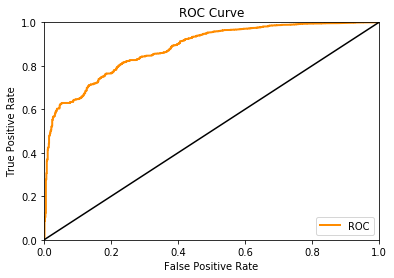

训练模型保存完成！


In [54]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]
all_train_models=[]

Total= 40                   #训练轮数
model_save_dir = '/home/aistudio/work/infer_model/' #模型保存路径
# 开始训练
for pass_id in range(Total):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):     #对于一个可迭代的（iterable）/可遍历的对象（如列表、字符串），enumerate将其组成一个索引序列，利用它可以同时获得索引和值
        train_cost, train_model, train_acc = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(data),
                             fetch_list=[avg_cost, model,acc])
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_models.append(train_model[0])
        all_train_accs.append(train_acc[0])
    print('Pass:%d' % (pass_id))
 # 测试集进行验证
all_eval_costs=[]
all_eval_accs=[]
all_eval_models=[]
eval_costs = []
eval_models=[]
eval_accs = []
eval_model_0=[]
for batch_id, data in enumerate(eval_reader()):
    eval_cost, eval_model, eval_acc = exe.run(program=test_program,
                                            feed=feeder.feed(data),
                                            fetch_list=[avg_cost, model,acc])
    eval_model_0.extend([_[0] for _ in eval_model])
    eval_costs.extend(eval_cost.tolist())
    eval_models.extend(eval_model.tolist())
    eval_accs.extend(eval_acc.tolist())
    all_eval_costs.extend(eval_cost.tolist())   
    all_eval_models.extend(eval_model.tolist())                                    
    all_eval_accs.extend(eval_acc.tolist())     

# 计算平均预测损失在，准确率，F1召回率、精确率、AUC
eval_cost = (sum(eval_costs) / len(eval_costs))
eval_acc = (sum(eval_accs) / len(eval_accs))
print('Test:, Cost:%0.5f, ACC:%0.5f' % (eval_cost, eval_acc))
model_predict=np.argmax(all_eval_models,axis=1)
model_true=list(map(int,model_true))
report = classification_report(model_true,model_predict, labels=[0,1],target_names=["非谣言", "谣言"])
print(report)


fpr, tpr, thresholds = sklearn.metrics.roc_curve(model_true, eval_model_0, pos_label=0)
print("AUC:",sklearn.metrics.auc(fpr, tpr))
plt.plot(fpr, tpr,color='darkorange',  label='ROC',lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],"k-")
plt.show()

# 保存模型
# 保存训练参数到之前给定的路径中
if not os.path.exists(model_save_dir): 
    os.makedirs(model_save_dir) 
fluid.io.save_inference_model(model_save_dir, 
                            feeded_var_names=[words.name], 
                            target_vars=[model], 
                            executor=exe)
print('训练模型保存完成！') 

In [55]:
# 用训练好的模型进行预测并输出预测结果
# 创建执行器
place = fluid.CPUPlace()
infer_exe = fluid.Executor(place)
infer_exe.run(fluid.default_startup_program())

save_path = '/home/aistudio/work/infer_model/'

# 从模型中获取预测程序、输入数据名称列表、分类器
[infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=save_path, executor=infer_exe)

# 获取数据
def get_data(sentence):
    # 读取数据字典
    with open('/home/aistudio/data/dict_split.txt', 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])
    dict_txt = dict(dict_txt)
    # 把字符串数据转换成列表数据
    keys = dict_txt.keys()
    data = []
    sentence=cut_word(sentence)
    for s in sentence.split(" "):
        # 判断是否存在未知字符
        if not s in keys:
            s = '<unk>'
        data.append(int(dict_txt[s]))
    return data

data = []
# 获取图片数据
data1 = get_data('中国这个被誉为“世界最大”的火车站，耗资130亿元！')
data2 = get_data('42岁刘涛出轨导致婚变，她该何去何从，所有人惊呆...')
data3 = get_data('BaBy又怀孕了，却招晓明机场暴打？原因竟然是……')
data.append(data1)
data.append(data2)
data.append(data3)

# 获取每句话的单词数量
base_shape = [[len(c) for c in data]]

# 生成预测数据
tensor_words = fluid.create_lod_tensor(data, base_shape, place)

# 执行预测
result = exe.run(program=infer_program,
                 feed={feeded_var_names[0]: tensor_words},
                 fetch_list=target_var)

# 分类名称
names = [ '非谣言', '谣言']

# 获取结果概率最大的label
for i in range(len(data)):
    lab = np.argsort(result)[0][i][-1]
    print('预测结果标签为：%d， 分类为：%s， 概率为：%f' % (lab, names[lab], result[0][i][lab]))

预测结果标签为：0， 分类为：非谣言， 概率为：0.984817
预测结果标签为：1， 分类为：谣言， 概率为：0.908611
预测结果标签为：1， 分类为：谣言， 概率为：0.897746
